# Определение возраста покупателей

## Исследовательский анализ данных

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

In [ ]:
df_labels = pd.read_csv('/datasets/faces/labels.csv')
df_labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


In [ ]:
df_labels.tail()

,file_name,real_age
7586,007608.jpg,14
7587,007609.jpg,37
7588,007610.jpg,28
7589,007611.jpg,20
7590,007612.jpg,47


In [ ]:
df_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [ ]:
df_labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


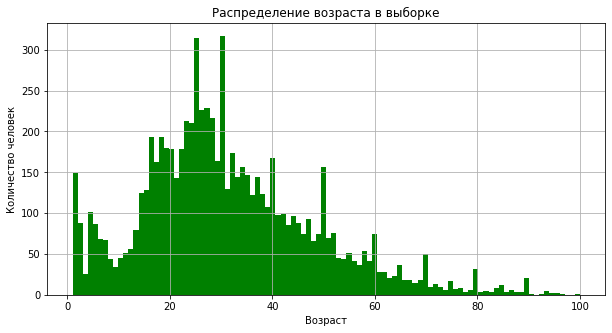

In [ ]:
df_labels.hist('real_age', bins=100, figsize=(10,5), color='g')
plt.xlabel('Возраст')
plt.ylabel('Количество человек')
plt.title('Распределение возраста в выборке')
plt.figsize=(15,10)
plt.show()

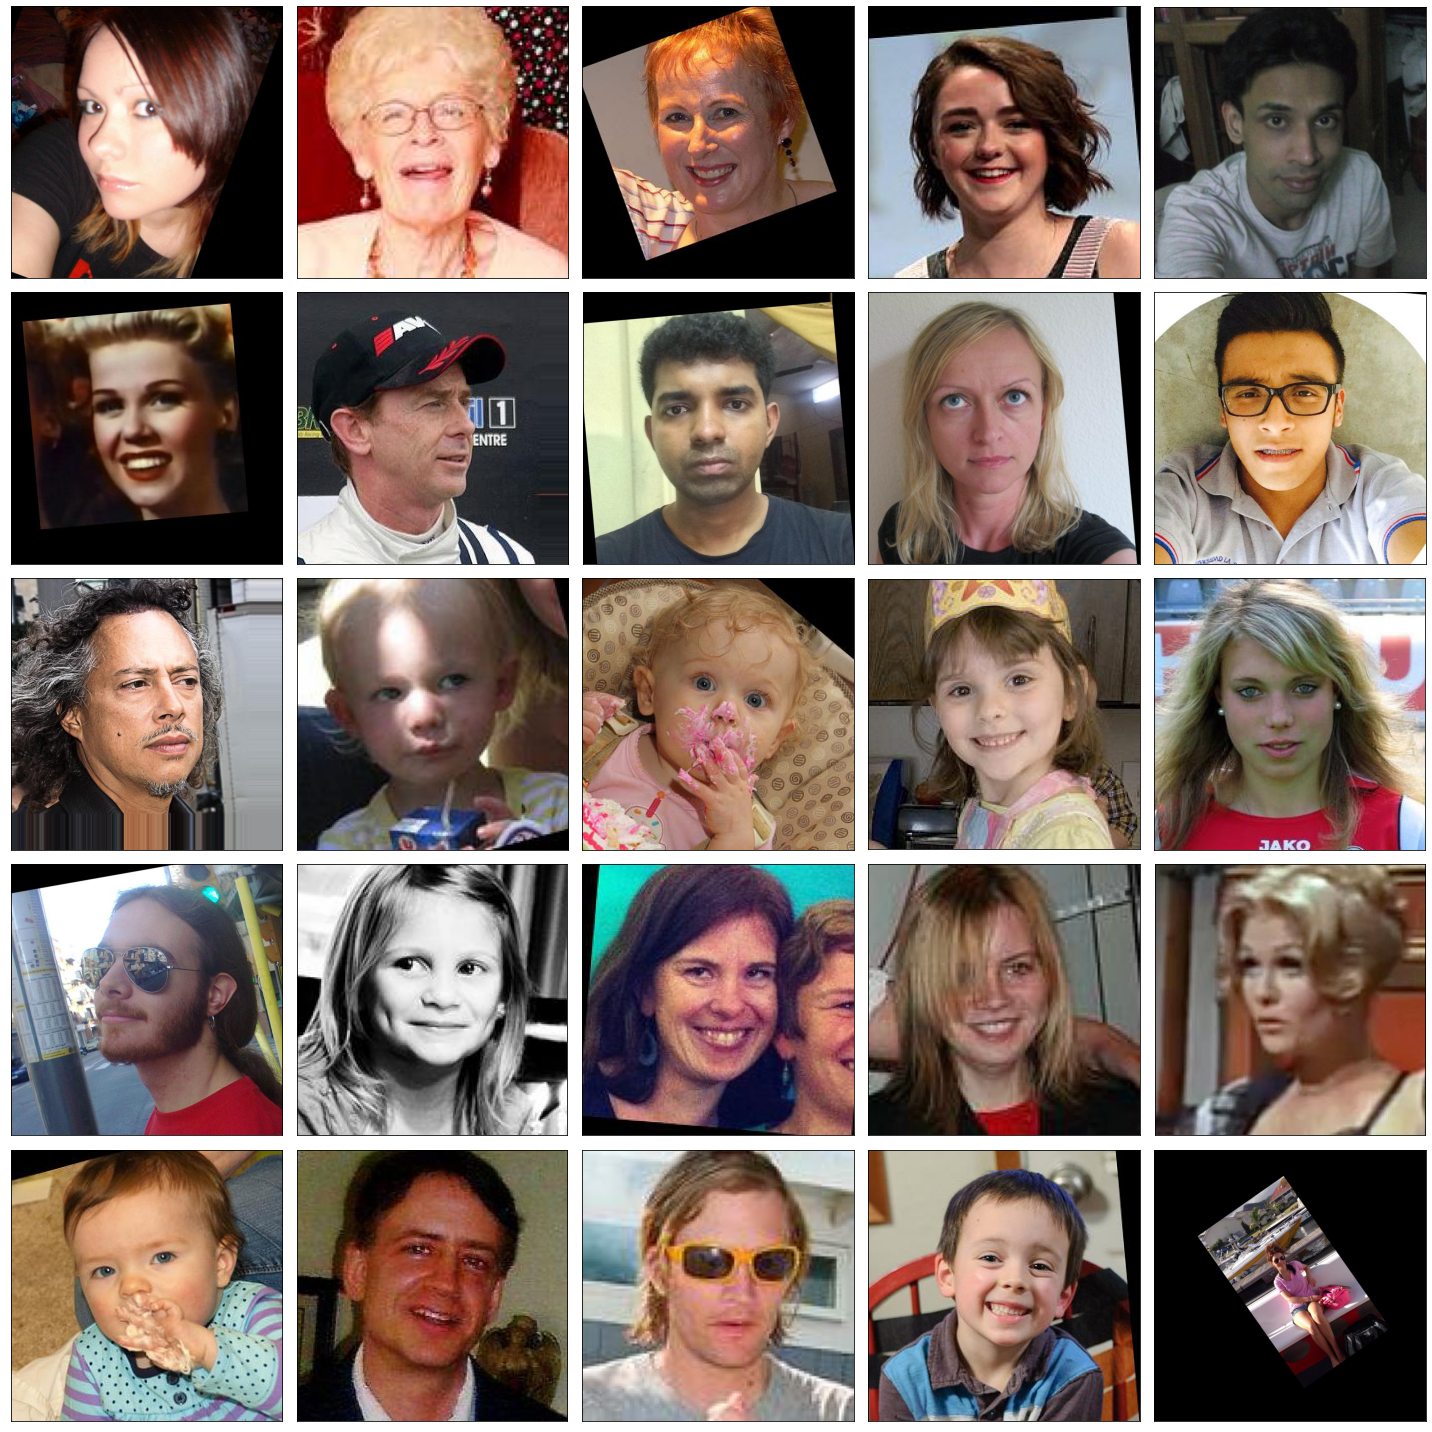

In [ ]:
list_pictures = []
for i in range(26):
    if i<=9:
        i = '00000'+ str(i)
    else:
        i = '0000'+str(i)
    list_pictures.append(i)




plt.figure(figsize=(20, 20))

for i in range(1,26):

    plt.subplot (5, 5, i)
    image = Image.open('/datasets/faces/final_files/'+list_pictures[i]+'.jpg')
    plt.imshow(np.array(image))
    plt.xticks([])#
    plt.yticks([])#
    plt.tight_layout()#

plt.show()

 - В выборке присутсвуют 7591 фотография.
 - Распределение в выборке неравномерное. Преобладают люди в возрасте от 20 до 40 лет, а также дети приблизительно до 7 лет. Можно будет ожидать, что модель будет лучше определять возраст той возрастной категории, которая преставлена в выборке большим количеством фотографий.
  - В датасете присутсвуют фото различного качества и разрешения ( с кропом, поворотом, цветные и ч/б фото)

## Обучение модели

```python

from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd


from tensorflow.keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import numpy as np
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.applications.resnet import ResNet50

def load_train(path):
    train_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255,
    horizontal_flip=True,
    )
    
    train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe = pd.read_csv(path + 'labels.csv'),
    directory=path + '/final_files',   
    x_col='file_name',
    y_col='real_age',
    target_size= (224, 224),
    class_mode='raw',
    batch_size=32,
    subset='training',
    seed=1234)
       
    return train_datagen_flow

def load_test(path):
    test_datagen = ImageDataGenerator(
    validation_split=0.25,
    rescale=1./255
    )
    
    test_datagen_flow = test_datagen.flow_from_dataframe(
    dataframe = pd.read_csv(path + 'labels.csv'),
    directory=path + '/final_files',   
    x_col='file_name',
    y_col='real_age',
    target_size= (224, 224),
    class_mode='raw',
    batch_size=32,
    subset='validation',
    seed=1234)

    return test_datagen_flow



def create_model(input_shape):
    optimizer = Adam(lr=0.0001)
    backbone = ResNet50(input_shape=input_shape,
                        weights='imagenet',
                        include_top=False)
   

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())

    model.add(Dense(1, activation='relu'))                              
    model.compile(optimizer=optimizer, loss='mse',
                  metrics=['mae'])
    return model



def train_model(model, train_data, test_data, batch_size=None, epochs=5,
               steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)

    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/5
2022-11-08 18:54:11.788601: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2022-11-08 18:54:12.080149: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 47s - loss: 244.4780 - mae: 11.1209 - val_loss: 1038.3361 - val_mae: 27.5002
Epoch 2/5
178/178 - 39s - loss: 77.4108 - mae: 6.6174 - val_loss: 945.2848 - val_mae: 25.8934
Epoch 3/5
178/178 - 39s - loss: 47.7510 - mae: 5.3022 - val_loss: 373.9297 - val_mae: 14.2766
Epoch 4/5
178/178 - 38s - loss: 36.3136 - mae: 4.5794 - val_loss: 121.6133 - val_mae: 8.3988
Epoch 5/5
178/178 - 38s - loss: 29.0464 - mae: 4.0982 - val_loss: 100.2174 - val_mae: 7.8613
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 9s - loss: 100.2174 - mae: 7.8613
Test MAE: 7.8613
```

## Анализ обученной модели

В данном проекте использовалась «остаточная сеть» с архитектурой ResNet50(бэкбон) в качестве головы использовались слои
 - model.add(GlobalAveragePooling2D())
 - model.add(Dense(1, activation='relu'))





 Параметры обучения:
 - Размер батча 32
 - Оптимизатор Adam
 -  Были загружены предобученные веса на датасете ImageNet
 -  Заморозка бэкбона не использовалась
 -  Количество эпох 5

 Была достигнута метрика MAE = 7.8613
 Наблюдалось переобучение( большая разница метрик на обучающей и тестовой выборках)